In [1]:
import pandas as pd

In [2]:
import pandas as pd

# Define bulans with filenames
bulans = [
    "01", "02", "03", "04", "05", "06",
    "07", "08", "09", "10", "11", "12"
]

agg_rules = {
    "Kinerja 2024": "sum",
    "Kinerja 2025": "sum",
    "Target Tahun Ini": "sum"
}

# List to store raw data with bulan
raw_list = []

for m in bulans:
    raw = pd.read_excel(f"data/performance/{m}2025.xlsx")
    raw["bulan"] = m   # add bulan before grouping
    raw_list.append(raw)

# Combine all raw data
raw_all = pd.concat(raw_list, ignore_index=True)

# Group once across all bulans
all_grouped = (
    raw_all
    .groupby(["bulan", "Categori Produk"])
    .agg(agg_rules)
    .reset_index()
)

# Add growth & achievement
all_grouped["growth"] = (
    (all_grouped["Kinerja 2025"] - all_grouped["Kinerja 2024"]) 
    / all_grouped["Kinerja 2024"] * 100
)
all_grouped["achievement"] = (
    all_grouped["Kinerja 2025"] / all_grouped["Target Tahun Ini"] * 100
)

all_grouped.to_csv("data/performance/performance_all.csv", index=False)


In [41]:
import calendar

# --- Revenue YtD ---
ytd = (
    all_grouped.groupby("Categori Produk")
    .agg({"Kinerja 2025": "sum", "Target Tahun Ini": "sum"})
    .reset_index()
)
ytd["YtD Achievement %"] = ytd["Kinerja 2025"] / ytd["Target Tahun Ini"] * 100

# --- Current bulan Revenue (MtD) ---
# Identify latest bulan in your data
latest_bulan = all_grouped["bulan"].max()

mtd = all_grouped[all_grouped["bulan"] == latest_bulan].copy()

# Derive bulanly target (full bulan) 
# Assumption: "Target Tahun Ini" is yearly, divide by 12
mtd["Target Bulanan"] = mtd["Target Tahun Ini"] / 12  
mtd["MtD Achievement %"] = mtd["Kinerja 2025"] / mtd["Target Bulanan"] * 100

# (Optional) pretty bulan name
mtd["bulan_name"] = mtd["bulan"].apply(lambda x: calendar.month_abbr[int(x)])

,Categori Produk,Kinerja 2025,Target Tahun Ini,YtD Achievement %
0,1. PLN,34519.383578,66059.201500,52.255224
1,10. WESEL LN,35973.260654,53386.410965,67.382804
2,11. METERAI,196279.243653,281999.999353,69.602569
3,12. FILATELI,8335.920600,17999.969024,46.310750
4,13. EBATARA & CICO,29992.826554,55999.983572,53.558635
5,14. ASURANSI & INVESTASI,1371.539582,2629.750056,52.154751
6,15. KREDIT PENSIUN,85665.406656,137293.698943,62.395731
7,16. MANFAAT PENSIUN,35946.727506,26076.259904,137.852313
8,17. PENYALURAN DANA NASIONAL,143523.529226,269592.509913,53.237209
9,18. PENYALURAN DANA DAERAH,4333.763840,9748.578597,44.455341


      month           real           pred
0   2025-01   61617.754280            NaN
1   2025-02  111884.933286            NaN
2   2025-03   75587.879147            NaN
3   2025-04   56978.851560            NaN
4   2025-05   68970.385217            NaN
5   2025-06   69615.727251            NaN
6   2025-07  146733.327295            NaN
7   2025-08   69032.700437            NaN
8   2025-09   18639.752371   50835.688285
9   2025-10       0.000000   96971.970895
10  2025-11       0.000000   99593.657456
11  2025-12       0.000000  102215.344017


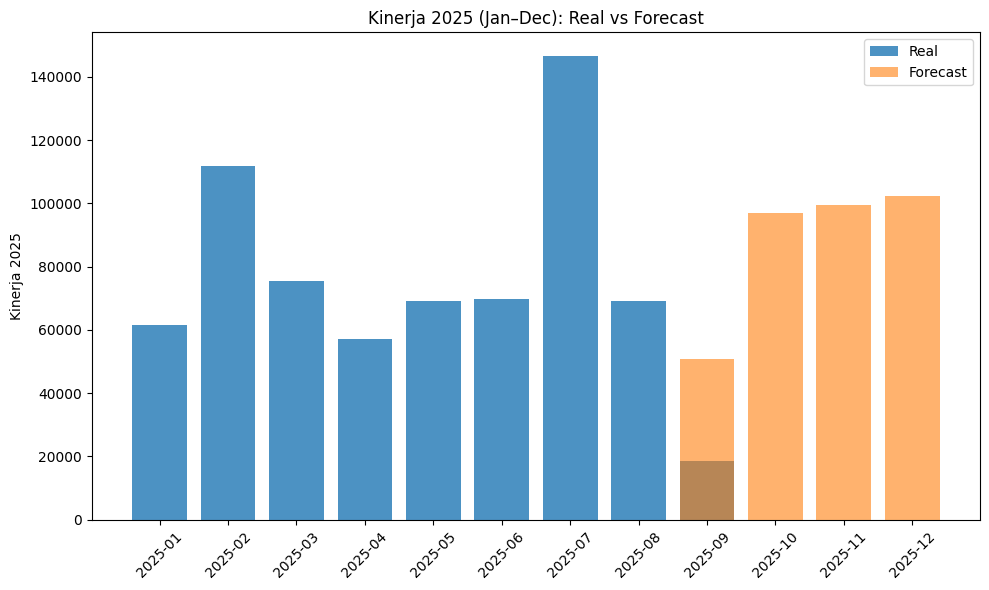

In [5]:
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

# --- Step 1: get monthly totals ---
monthly_real = (
    raw_all.groupby("bulan")["Kinerja 2025"]
    .sum()
    .reindex(bulans)  # ensure all months Jan–Dec appear
    .reset_index()
)
monthly_real.columns = ["bulan", "Kinerja 2025"]

# --- Step 2: scale September (partial data → full month) ---
raw_sep = raw_all[raw_all["bulan"] == "09"]
if "Tanggal" in raw_sep:
    days_reported = raw_sep["Tanggal"].nunique()
else:
    days_reported = 11  # fallback assumption
scale_factor = 30 / days_reported
sep_real = monthly_real.loc[monthly_real["bulan"] == "09", "Kinerja 2025"].values[0]
sep_pred = sep_real * scale_factor

# --- Step 3: build training data (Jan–Aug) for regression ---
train_months = np.arange(1, 9).reshape(-1, 1)  # 1–8
train_values = monthly_real.loc[monthly_real["bulan"].astype(int) <= 8, "Kinerja 2025"].values

model = LinearRegression()
model.fit(train_months, train_values)

# --- Step 4: forecast Oct–Dec using regression ---
future_months = np.arange(10, 13).reshape(-1, 1)  # 10–12
future_preds = model.predict(future_months)

# --- Step 5: assemble final DataFrame ---
forecast_df = pd.DataFrame({
    "month": [f"2025-{m:02d}" for m in range(1, 13)],
    "real": monthly_real["Kinerja 2025"].tolist(),
    "pred": [np.nan]*12   # use np.nan instead of None
})

# overwrite September pred with scaled version
forecast_df.loc[8, "pred"] = sep_pred   # index 8 = September

# overwrite Oct–Dec pred with regression forecasts
forecast_df.loc[9:11, "pred"] = future_preds

print(forecast_df)

# --- Step 6: bar plot ---
plt.figure(figsize=(10,6))
plt.bar(forecast_df["month"], forecast_df["real"], label="Real", alpha=0.8)
plt.bar(forecast_df["month"], forecast_df["pred"], label="Forecast", alpha=0.6)
plt.xticks(rotation=45)
plt.ylabel("Kinerja 2025")
plt.title("Kinerja 2025 (Jan–Dec): Real vs Forecast")
plt.legend()
plt.tight_layout()
plt.show()

In [6]:
# Build final column: use real if not NaN, otherwise use pred
forecast_df["final"] = forecast_df["real"].fillna(forecast_df["pred"])

# Total Kinerja 2025 (real + forecast)
total_2025 = forecast_df["final"].sum()

print("Total Kinerja 2025 (real + forecast):", total_2025)

Total Kinerja 2025 (real + forecast): 679061.3108442384


In [7]:
forecast_df.to_excel("data/performance/performance_forecast.xlsx", index=False)

      month  real_excl_dana  real_with_dana          pred  final_excl_dana
0   2025-01    61494.511461    61617.754280           NaN     61494.511461
1   2025-02    64481.424005   111884.933286           NaN     64481.424005
2   2025-03    62043.919914    75587.879147           NaN     62043.919914
3   2025-04    54357.758438    56978.851560           NaN     54357.758438
4   2025-05    66864.141980    68970.385217           NaN     66864.141980
5   2025-06    68979.420229    69615.727251           NaN     68979.420229
6   2025-07    70929.904833   146733.327295           NaN     70929.904833
7   2025-08    63142.614867    69032.700437           NaN     63142.614867
8   2025-09    18639.752371    18639.752371  50835.688285     18639.752371
9   2025-10        0.000000        0.000000  69084.403259         0.000000
10  2025-11        0.000000        0.000000  70002.165312         0.000000
11  2025-12        0.000000        0.000000  70919.927366         0.000000
Total excl Dana (Real + F

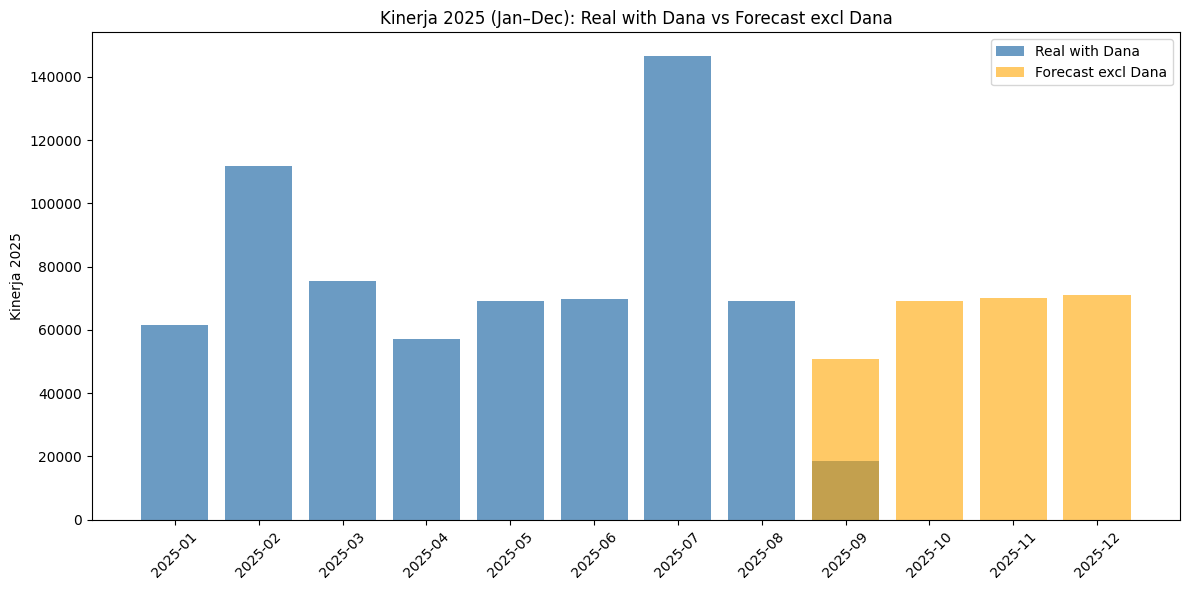

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# -------------------------
# 1. Setup & Read All Files
# -------------------------
bulans = [f"{i:02d}" for i in range(1, 13)]

raw_list = []
for m in bulans:
    raw = pd.read_excel(f"data/performance/{m}2025.xlsx")
    raw["bulan"] = m
    raw_list.append(raw)

raw_all = pd.concat(raw_list, ignore_index=True)

# -------------------------
# 2. Exclude kategori Dana untuk Forecasting
# -------------------------
exclude_list = [
    "17. PENYALURAN DANA NASIONAL",
    "18. PENYALURAN DANA DAERAH",
    "19. PENYALURAN DANA KORPORAT"
]

# Monthly total tanpa Dana (untuk forecasting)
monthly_real_excl = (
    raw_all[~raw_all["Categori Produk"].isin(exclude_list)]
    .groupby("bulan")["Kinerja 2025"]
    .sum()
    .reindex(bulans)
    .reset_index()
)
monthly_real_excl.columns = ["bulan", "Kinerja 2025_excl"]

# Monthly total dengan Dana (untuk laporan real)
monthly_real_incl = (
    raw_all.groupby("bulan")["Kinerja 2025"]
    .sum()
    .reindex(bulans)
    .reset_index()
)
monthly_real_incl.columns = ["bulan", "Kinerja 2025_incl"]

# -------------------------
# 3. Scale September (pakai excl Dana)
# -------------------------
raw_sep = raw_all[
    (raw_all["bulan"] == "09") & (~raw_all["Categori Produk"].isin(exclude_list))
]

if "Tanggal" in raw_sep:
    days_reported = raw_sep["Tanggal"].nunique()
else:
    days_reported = 11  # fallback
scale_factor = 30 / days_reported

sep_real = monthly_real_excl.loc[monthly_real_excl["bulan"] == "09", "Kinerja 2025_excl"].values[0]
sep_pred = sep_real * scale_factor

# -------------------------
# 4. Train Regression (Jan–Aug excl Dana) & Forecast Oct–Dec
# -------------------------
train_months = np.arange(1, 9).reshape(-1, 1)
train_values = monthly_real_excl.loc[
    monthly_real_excl["bulan"].astype(int) <= 8, "Kinerja 2025_excl"
].values

model = LinearRegression()
model.fit(train_months, train_values)

future_months = np.arange(10, 13).reshape(-1, 1)
future_preds = model.predict(future_months)

# -------------------------
# 5. Build Final DataFrame
# -------------------------
forecast_df = pd.DataFrame({
    "month": [f"2025-{m:02d}" for m in range(1, 13)],
    "real_excl_dana": monthly_real_excl["Kinerja 2025_excl"].tolist(),
    "real_with_dana": monthly_real_incl["Kinerja 2025_incl"].tolist(),
    "pred": [np.nan]*12
})

# isi forecast Sep–Dec
forecast_df.loc[8, "pred"] = sep_pred
forecast_df.loc[9:11, "pred"] = future_preds

# kolom final = real_excl_dana (kalau ada), kalau kosong pakai pred
forecast_df["final_excl_dana"] = forecast_df["real_excl_dana"].fillna(forecast_df["pred"])

# -------------------------
# 6. Hitung Total
# -------------------------
total_2025_excl_dana = forecast_df["final_excl_dana"].sum()
total_2025_with_dana = forecast_df["real_with_dana"].sum(skipna=True)

print(forecast_df)
print("Total excl Dana (Real + Forecast):", total_2025_excl_dana)
print("Total with Dana (Real only):", total_2025_with_dana)

# -------------------------
# 7. Plot
# -------------------------
plt.figure(figsize=(12,6))

# Real with Dana
plt.bar(
    forecast_df["month"],
    forecast_df["real_with_dana"],
    label="Real with Dana",
    alpha=0.8,
    color="steelblue"
)

# Forecast excl Dana
plt.bar(
    forecast_df["month"],
    forecast_df["pred"],
    label="Forecast excl Dana",
    alpha=0.6,
    color="orange"
)

plt.xticks(rotation=45)
plt.ylabel("Kinerja 2025")
plt.title("Kinerja 2025 (Jan–Dec): Real with Dana vs Forecast excl Dana")
plt.legend()
plt.tight_layout()
plt.show()


In [12]:
forecast_df.to_excel("data/performance/performance_forecast_fix.xlsx", index=False)

In [16]:
# -------------------------
# 8. Aggregate by Product Group - Monthly
# -------------------------

# 1. Real (with Dana)
monthly_real_group = (
    raw_all.groupby(["bulan", "product_group"])["Kinerja 2025"]
    .sum()
    .reset_index()
)

# 2. Shares (Jan–Aug, excl Dana)
mask = (raw_all["bulan"].astype(int) <= 8) & (raw_all["product_group"] != "Dana")
shares = (
    raw_all[mask]
    .groupby("product_group")["Kinerja 2025"]
    .sum()
)
shares = shares / shares.sum()

# 3. Forecast by month (Sep–Dec, excl Dana)
forecast_months = forecast_df.loc[8:11, ["month", "pred"]].copy()
forecast_months["bulan"] = forecast_months["month"].str[-2:]  # ambil "09","10","11","12"

# distribusi forecast bulanan ke tiap group
monthly_pred_group = []
for _, row in forecast_months.iterrows():
    bulan = row["bulan"]
    total_pred = row["pred"]
    dist = (shares * total_pred).reset_index()
    dist.columns = ["product_group", "pred"]
    dist["bulan"] = bulan
    monthly_pred_group.append(dist)

monthly_pred_group = pd.concat(monthly_pred_group, ignore_index=True)

# 4. Gabungkan real + pred
monthly_summary = pd.merge(
    monthly_real_group,
    monthly_pred_group,
    on=["bulan", "product_group"],
    how="outer"
).fillna(0)

# biar urut
monthly_summary["bulan"] = monthly_summary["bulan"].astype(str).str.zfill(2)
monthly_summary = monthly_summary.sort_values(["bulan", "product_group"])

print(monthly_summary.head(20))

   bulan       product_group  Kinerja 2025  pred
0     01            Bendapos   1380.011100   0.0
1     01                Dana    123.242819   0.0
2     01             Meterai  23334.791354   0.0
3     01      Modern Channel   2270.473087   0.0
4     01             Payment  11411.912946   0.0
5     01  Pensiun & Asuransi  13401.884487   0.0
6     01           Remitansi   5419.901483   0.0
7     01             Syariah    425.792473   0.0
8     01   eBatarapos & CICO   3849.744530   0.0
9     02            Bendapos   1101.290700   0.0
10    02                Dana  47403.509281   0.0
11    02             Meterai  24527.372788   0.0
12    02      Modern Channel   2301.658754   0.0
13    02             Payment  11868.109109   0.0
14    02  Pensiun & Asuransi  15492.998066   0.0
15    02           Remitansi   5294.030784   0.0
16    02             Syariah    546.784764   0.0
17    02   eBatarapos & CICO   3349.179040   0.0
18    03            Bendapos   1058.379400   0.0
19    03            

In [18]:
monthly_summary.to_excel("data/performance/performance_by_product_group.xlsx", index=False)

In [20]:
# -------------------------
# Special Forecast for eBatarapos & CICO
# -------------------------

# Ambil data Jan–Aug khusus eBatarapos
ebata = (
    raw_all[(raw_all["product_group"] == "eBatarapos & CICO")]
    .groupby("bulan")["Kinerja 2025"]
    .sum()
    .reindex([f"{i:02d}" for i in range(1, 9)])  # Jan–Aug
)

jan_val = ebata.loc["01"]
jul_val = ebata.loc["07"]
aug_val = ebata.loc["08"]

# monthly growth profile dari Jan–Jul
monthly_growth = (jul_val / jan_val) ** (1/6) - 1   # rata-rata pertumbuhan bulanan

# Forecast Sep–Dec dengan base Agustus
ebata_forecast = {}
last_val = aug_val
for m in ["09","10","11","12"]:
    next_val = last_val * (1 + monthly_growth)
    ebata_forecast[m] = next_val
    last_val = next_val

ebata_forecast = pd.DataFrame({
    "bulan": list(ebata_forecast.keys()),
    "product_group": "eBatarapos & CICO",
    "pred": list(ebata_forecast.values())
})

In [21]:
# drop pred lama untuk eBatarapos & CICO di Sep–Dec
monthly_pred_group = monthly_pred_group[
    ~((monthly_pred_group["product_group"] == "eBatarapos & CICO") & 
      (monthly_pred_group["bulan"].isin(["09","10","11","12"])))
]

# tambahkan pred baru
monthly_pred_group = pd.concat([monthly_pred_group, ebata_forecast], ignore_index=True)

In [23]:
monthly_pred_group.to_excel("data/performance/performance_pred_by_product_group_ebatarafix.xlsx", index=False)